In [92]:
import math
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("archive\\car_detail_en.csv")
# set seed for reproducibility|
np.random.seed(0) 


In [93]:
df.sample(5).T

,15156,23155,30274,25368,11400
ad_id,4864188,4903796,4929084,4911886,4838870
origin,Domestic assembly,Domestic assembly,Imported,Domestic assembly,Domestic assembly
condition,Used car,Used car,New car,Used car,Used car
car_model,Sedan,SUV,Sedan,SUV,SUV
mileage,"75,000 Km","60,000 Km",0 Km,"10,522 Km","60,000 Km"
exterior_color,White,Black,White,White,Green
interior_color,Black,Different color,Black,Black,Black
num_of_doors,4-door,5-door,4-door,5-door,5-door
seating_capacity,5-seat,5-seat,5-seat,5-seat,5-seat
engine,Petrol\t2.0 L,Petrol\t1.5 L,Petrol\t2.5 L,Petrol\t2.0 L,Petrol\t2.0 L


In [94]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()
# look at the # of missing points in the first ten columns
missing_values_count

ad_id                      0
origin                     0
condition                  0
car_model                  0
mileage                    0
exterior_color             0
interior_color             0
num_of_doors               0
seating_capacity           0
engine                     0
fuel_system            23910
transmission               0
drive_type                 0
fuel_consumption           0
describe                   0
brand                      0
grade                      0
year_of_manufacture       32
car_name                   0
price. price               0
url                        0
dtype: int64

In [95]:
# Prints the number of duplicates that were removed
item0 = df.shape[0] 
item1 = df.shape[0]
print(f"There are {item0-item1} duplicates found in the dataset")
# Check datatypes
df.dtypes

There are 0 duplicates found in the dataset


ad_id                    int64
origin                  object
condition               object
car_model               object
mileage                 object
exterior_color          object
interior_color          object
num_of_doors            object
seating_capacity        object
engine                  object
fuel_system             object
transmission            object
drive_type              object
fuel_consumption        object
describe                object
brand                   object
grade                   object
year_of_manufacture    float64
car_name                object
price. price            object
url                     object
dtype: object

**There are missing values in columns "fuel", and "year_of_manufacture". It should be fixed.**

**Data Preprocessing Tasks:**

**1.** Convert the `mileage` field from object data type (format "... Km") to logarithmic scale base 10 for calculation.

**2.** Convert the `fuel_consumption` field from object data type (format "...\L/100Km") to numeric data type and remove the "\L/100Km" component. Some values might not have units (e.g., L/100Km), they will be converted to None.

**3.** Clean and standardize the `fuel_system` field based on the `engine` field to create a `fuel_type` field representing the type of fuel the vehicle uses and an `engine_size` field representing the fuel tank capacity of the vehicle.

**4.** Process the `price` field. If the price format is "... Million" or "... Billion", remove the suffix and convert to logarithmic scale base 10.

**5.** Combine `brand` and `grade` fields.

**Description:**
The `fuel_system` field contains inconsistent and incomplete data related to the fuel systems of vehicles. To improve data consistency and completenessthe following changes:
- Introduce a new field `fuel_type` to replace `fuel_system`. This field will represent the type of fuel the vehicle uses (e.g., gasoline, diesel, electric).
- Introduce a new field `engine_size` to represent the fuel capacity of the vehicle. This field will provide information about the engine's displacement, which correlates with fuel capacity.

By utilizing the `engine` field along with the proposed `fuel_type` and `engine_size` fields, we can enhance data clarity and usefulness regarding vehicle fuel information.




In [96]:
#1 - mileage

def n_mileage(x):
    try:
        # Chuyển đổi giá trị sang kiểu số nguyên, loại bỏ ' Km', loại bỏ dấu ',' và thực hiện phép nhân với 1000
        return int(str(x).rstrip(' Km').replace(',',''))
    except:
        # Trả về 0 nếu giá trị không hợp lệ
        return 0

# Áp dụng hàm n_mileage vào cột 'mileage' và tạo một cột mới 'n_mileage'
df['n_mileage'] = df['mileage'].apply(n_mileage)


#2 - fuel_consumption

def get_fuel_consumption(x):
    res = str(x).replace('L/100Km','').rstrip('\t')
    if res:
        return res
    else:
        return 'None'
df['fuel_consumption'] = df['fuel_consumption'].apply(get_fuel_consumption)

#3 fuel_system -> fuel_type; engine

df['fuel_type'] = df['engine'].apply(lambda x: str(x).split('\t')[0])
def get_engine_size(x):
    res = str(x).split('\t')[-1]
    if ' L' in res:
        return res
    else:
        return 'None'
df['engine_size'] = df['engine'].apply(get_engine_size)
df['fuel_type'] = df['engine'].apply(lambda x: str(x).split('\t')[0])

#4 price. price -> car_price

def convert_to_numeric(value):
    try:
        if 'Billion' in value and not 'Million' in value:
            return float(value.replace('Billion', '').replace(' ', '')) * 1e3
        elif 'Million' in value and not 'Billion' in value:
            return float(value.replace('Million', '').replace(' ', ''))
        else:
            parts = value.split()
            billion_part = parts[0]  
            million_part = parts[2]  
            billion_value = float(billion_part.replace('Billion', '').replace(' ', '')) * 1e3
            million_value = float(million_part.replace('Million', '').replace(' ', ''))
            return billion_value + million_value
    except:
        return None
df['car_price'] = df['price. price'].apply(convert_to_numeric).astype(float)

df = df[~df['car_price'].isnull()]

#5 brand + grade

df['brand_grade'] = df['brand'] + ' ' + df['grade']

#6 Replace value "-" with "Hibrid" in column "transmission"
df['transmission'] = df['transmission'].replace('-', 'Hybrid')

#7 Loại bỏ các hàng chứa giá trị NaN trong cột 'year_of_manufacture'
df.dropna(subset=['year_of_manufacture'], inplace=True)
df['year_of_manufacture'] = df['year_of_manufacture'].astype(int)


--------------------------------------------------------------------------

----------------------

# Select only specific columns of interest

In [97]:
selected_cols = ['car_price', 'origin', 'condition', 'car_model', 'n_mileage',
       'exterior_color', 'interior_color', 'num_of_doors', 'seating_capacity',
       'fuel_type', 'engine_size', 'transmission', 'drive_type',
       'fuel_consumption','brand', 'grade', 'brand_grade', 'year_of_manufacture']
df = df[selected_cols]

print(df.shape)
df.sample(10).T

(30267, 18)


,25969,20507,17082,15451,26276,24882,20642,29906,17086,30412
car_price,350.00,3190.00,295.00,235.00,5200.00,495.00,319.00,468.00,440.00,840.00
origin,Domestic assembly,Imported,Domestic assembly,Domestic assembly,Imported,Domestic assembly,Domestic assembly,Domestic assembly,Domestic assembly,Imported
condition,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car,New car
car_model,SUV,SUV,Hatchback,Sedan,Bán tải / Pickup,Sedan,Sedan,Sedan,Sedan,Bán tải / Pickup
n_mileage,100000,136765,0,141000,1100,50000,69000,67000,72800,0
exterior_color,Take note,Black,Red,Silver,Black,Red,Brown,White,Sand,Red
interior_color,gray,Black,Black,Cream,Brown,Black,Cream,Cream,Sand,Black
num_of_doors,5-door,5-door,5-door,4-door,4-door,4-door,4-door,4-door,4-door,4-door
seating_capacity,8-seat,7-seat,5-seat,5-seat,5-seat,5-seat,5-seat,5-seat,5-seat,5-seat
fuel_type,Diesel,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Diesel


In [98]:
df.columns

Index(['car_price', 'origin', 'condition', 'car_model', 'n_mileage',
       'exterior_color', 'interior_color', 'num_of_doors', 'seating_capacity',
       'fuel_type', 'engine_size', 'transmission', 'drive_type',
       'fuel_consumption', 'brand', 'grade', 'brand_grade',
       'year_of_manufacture'],
      dtype='object')

In [99]:
df.nunique()

car_price              2165
origin                    2
condition                 2
car_model                10
n_mileage              1901
exterior_color           18
interior_color           18
num_of_doors             12
seating_capacity         23
fuel_type                 5
engine_size              60
transmission              3
drive_type                6
fuel_consumption         74
brand                    76
grade                   473
brand_grade             495
year_of_manufacture      34
dtype: int64

In [100]:
# Đặt số lượng chữ số thập phân cần hiển thị
pd.options.display.float_format = '{:.2f}'.format

# Sử dụng describe() trên DataFrame df
df.describe()


,car_price,n_mileage,year_of_manufacture
count,30267.00,30267.00,30267.00
mean,1174.57,411464.68,2017.34
std,2070.96,35110338.85,5.29
min,18.00,0.00,1990.00
25%,410.00,0.00,2015.00
50%,620.00,20000.00,2019.00
75%,1015.00,60000.00,2022.00
max,54000.00,4294967295.00,2023.00


In [101]:
df['car_price'].max()

54000.0

_________________

-------------------

# Start our analysis with visualizations:

In [102]:
# Let's make price bins and a pie chart 

groups1 = np.array([1., 700., 2000., 5000., 60000.])
group_names1 = ['< 700 million VND' , '700-2000 million VND', '2000-5000 million VND', '5000+ million VND']
df['price-bin'] = pd.cut(df['car_price'], groups1, labels = group_names1, include_lowest = True)
df[['car_price', 'price-bin']].head(10)

,car_price,price-bin
0,249.00,< 700 million VND
1,4286.00,2000-5000 million VND
2,885.00,700-2000 million VND
3,754.00,700-2000 million VND
4,850.00,700-2000 million VND
5,299.00,< 700 million VND
6,984.00,700-2000 million VND
7,1229.00,700-2000 million VND
8,688.00,< 700 million VND
9,830.00,700-2000 million VND


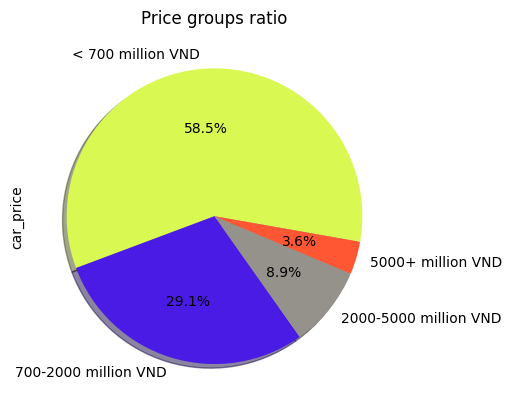

In [103]:
pie_price_bins = df.groupby(['price-bin'], observed=False).count()
plot = pie_price_bins.plot.pie(y = 'car_price', title="Price groups ratio", legend=False,
                   autopct='%1.1f%%', colors = ['#d9f852', '#4a1be4', '#95928c', '#ff5733',],
                   shadow=True, startangle=350)
plt.savefig('Price groups ratio.png')

> There are a staggering 51.5% of cars priced between 300 million and 800 million Vietnamese dong.

In [104]:
df['price-bin'].value_counts()

price-bin
< 700 million VND        17700
700-2000 million VND      8802
2000-5000 million VND     2681
5000+ million VND         1084
Name: count, dtype: int64

> Define a function to label each `n_mileage` value with detailed notation

In [105]:
# Define a function to label each 'n_mileage' value with detailed notation
def label_mileage(n_mileage, condition):
    if condition == 'New car':
        return 'New Car'
    elif n_mileage < 50000:
        return f'Low Mileage (< 50,000 km)'
    elif 50000 <= n_mileage < 100000:
        return f'Moderate Mileage (50,000 - 100,000 km)'
    elif 100000 <= n_mileage < 200000:
        return f'High Mileage (100,000 - 200,000 km)'
    else:
        return f'Very High Mileage (> 200,000 km)'

# Sử dụng apply() để áp dụng hàm label_mileage cho mỗi hàng trong DataFrame
df['mileage_label'] = df.apply(lambda row: label_mileage(row['n_mileage'], row['condition']), axis=1)

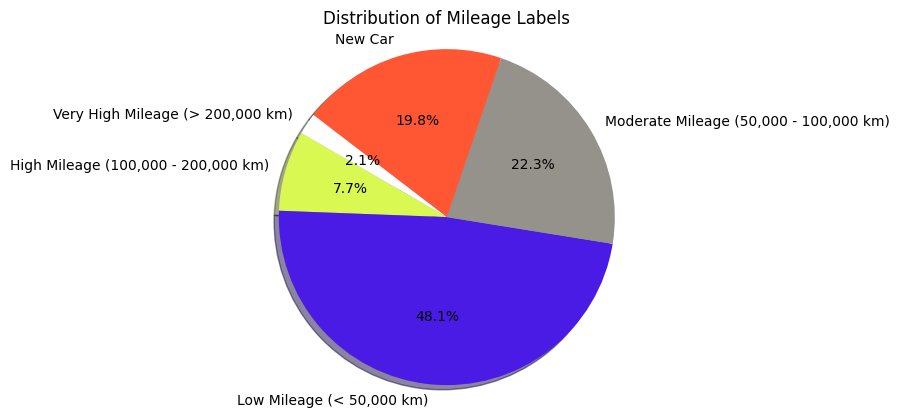

In [106]:
# Nhóm theo cột 'mileage_label' và đếm số lượng mỗi nhóm
pie_df = df.groupby(['mileage_label']).size()

# Vẽ biểu đồ pie
plot = pie_df.plot.pie(title="Distribution of Mileage Labels", autopct='%1.1f%%', 
                        colors=['#d9f852', '#4a1be4', '#95928c', '#ff5733', '#ffffff', '#7cfc00'],
                       shadow=True, startangle=150)
# Hiển thị biểu đồ
plt.ylabel('')  # Xóa nhãn trục y
plt.axis('equal')  # Đảm bảo biểu đồ là hình tròn
plt.show()


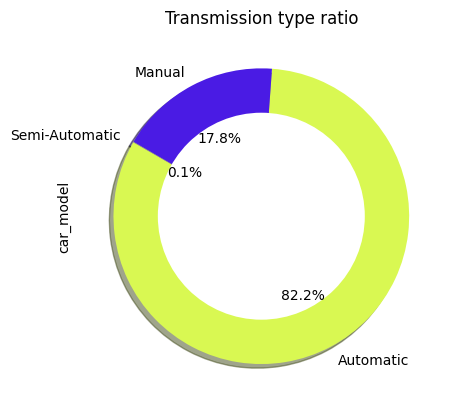

In [107]:
# Change 'Hybrid' value with 'Semi-Automatic'
df.replace({'transmission': {'Hybrid': 'Semi-Automatic'}}, inplace=True)

# Check gear type ratio
pie_gear = df.groupby(['transmission']).count()
plot_gear = pie_gear.plot.pie(y = 'car_model', title="Transmission type ratio", legend=False,
                   autopct='%1.1f%%', colors = ['#d9f852','#4a1be4' , '#95928c'],
                   shadow=True, startangle=150)
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Add circle to the pie chart
fig.gca().add_artist(centre_circle)
plt.savefig('Transmission type ratio.png')

In [108]:
df['transmission'].value_counts()

transmission
Automatic         24874
Manual             5376
Semi-Automatic       17
Name: count, dtype: int64

In [109]:
# Check fuel type value_counts
df['fuel_type'].value_counts()

fuel_type
Petrol      24410
Diesel       5287
Electric      295
Hybrid        251
-              24
Name: count, dtype: int64

In [110]:
df.loc[df['fuel_type'] == '-'].T

,4418,28992,29279,29375,29467,29494,29550,29619,29706,29858,...,30091,30151,30158,30215,30233,30273,30321,30328,30372,30422
car_price,2890.00,720.00,879.00,235.00,266.00,298.00,139.00,395.00,525.00,4300.00,...,525.00,470.00,1479.00,368.00,665.00,183.00,380.00,170.00,375.00,245.00
origin,Imported,Domestic assembly,Imported,Imported,Imported,Imported,Domestic assembly,Domestic assembly,Domestic assembly,Imported,...,Domestic assembly,Domestic assembly,Imported,Imported,Domestic assembly,Imported,Imported,Imported,Domestic assembly,Domestic assembly
condition,New car,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car,...,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car
car_model,SUV,SUV,SUV,Sedan,Sedan,Sedan,Hatchback,Sedan,Crossover,Sedan,...,Sedan,Sedan,Sedan,Hatchback,SUV,Hatchback,SUV,Hatchback,SUV,SUV
n_mileage,0,40000,50000,90000,125000,13000,88000,38000,0,59000,...,30000,1050,31000,47000,53000,80000,0,0,1000,0
exterior_color,Black,White,Red,-,Silver,Violet,Green,Red,-,Black,...,-,-,-,Red,White,Red,-,-,Yellow,Sand
interior_color,Brown,White,Black,-,-,-,-,Black,-,Cream,...,-,-,-,Red,Brown,Cream,-,-,Black,Black
num_of_doors,5-door,4-door,0-door,0-door,0-door,0-door,0-door,4-door,0-door,0-door,...,0-door,0-door,0-door,5-door,5-door,0-door,0-door,0-door,4-door,5-door
seating_capacity,5-seat,7-seat,0-seat,0-seat,0-seat,0-seat,0-seat,5-seat,0-seat,0-seat,...,0-seat,0-seat,0-seat,5-seat,7-seat,0-seat,0-seat,7-seat,8-seat,0-seat
fuel_type,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


> Checking information about models of cars that have "-" fuel types, we can find out that almost all of them may possibly have Petrol fuel types.

In [111]:
# Replace '-' value with 'Petrol' 

df.replace({'fuel_type': {'-': 'Petrol'}}, inplace=True)


In [112]:
df['fuel_type'].value_counts()

fuel_type
Petrol      24434
Diesel       5287
Electric      295
Hybrid        251
Name: count, dtype: int64

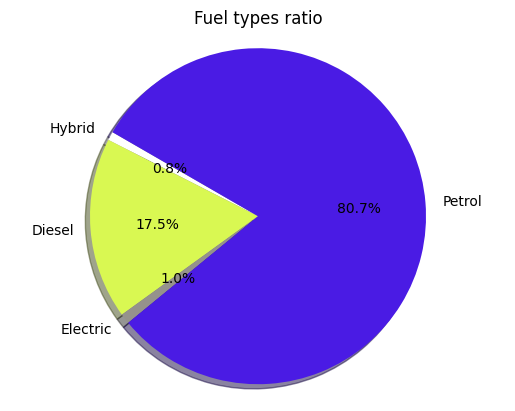

In [113]:

# Tính tỷ lệ của mỗi loại nhiên liệu
fuel_ratios = df.groupby(['fuel_type']).size()
fuel_ratios = fuel_ratios.reindex(['Hybrid', 'Diesel', 'Electric', 'Petrol'])
# Vẽ biểu đồ tròn
plot = fuel_ratios.plot.pie(title="Fuel types ratio", legend=False,
                            autopct='%1.1f%%', colors=['#ffffff', '#d9f852','#95928c', '#4a1be4'],
                            shadow=True, startangle=150)

plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.ylabel('')  # Xóa nhãn trục y
plt.savefig('Fuel types ratio.png')
plt.show()

----------------------------------

## Let's investigate offer type column:

In [114]:
df['condition'].value_counts() 

condition
Used car    24264
New car      6003
Name: count, dtype: int64

> No surprises almost all offer types are Used car. We can also group values in a column to check the ratio between New and Used cars.

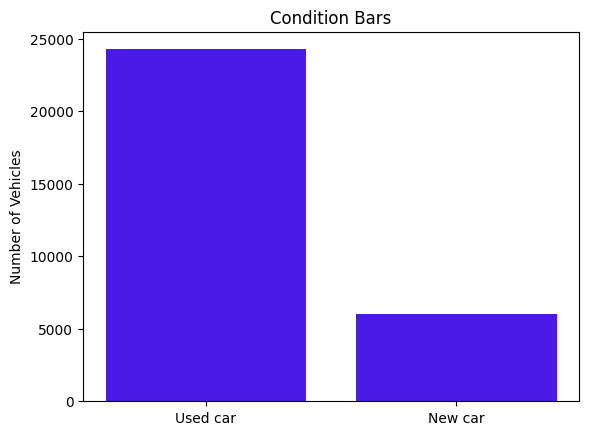

In [115]:
# Tạo biểu đồ cột
plt.bar(df['condition'].value_counts().index, df['condition'].value_counts().values, color='#4a1be4')

# Đặt nhãn cho trục x và y
plt.ylabel('Number of Vehicles')
plt.title('Condition Bars')
plt.savefig('Condition Bars.png')

# Statistical analysis:

<b>Now we are going to check some relationships between numeric variables.</b>

In [116]:
df[['car_price', 'n_mileage', 'year_of_manufacture']].corr()

,car_price,n_mileage,year_of_manufacture
car_price,1.00,0.00,0.22
n_mileage,0.00,1.00,-0.01
year_of_manufacture,0.22,-0.01,1.00


In [117]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(df['car_price'], df['n_mileage'])
print('The Pearson correlation is', pearson_coef, 'p-value is', '{:.2f}'.format(p_value))

The Pearson correlation is 0.00450865912955929 p-value is 0.43


In [118]:
pearson_coef, p_value = stats.pearsonr(df['year_of_manufacture'], df['n_mileage'])
print('The Pearson correlation is', pearson_coef, 'p-value is', '{:.2f}'.format(p_value))

The Pearson correlation is -0.01102831455456152 p-value is 0.06


In [119]:
pearson_coef, p_value = stats.pearsonr(df['car_price'], df['year_of_manufacture'])
print('The Pearson correlation is', pearson_coef, 'p-value is', '{:.2f}'.format(p_value))

The Pearson correlation is 0.2204936264805185 p-value is 0.00


Kết quả nhận được khi tính toán hệ số tương quan Pearson và giá trị p giữa cột 'year_of_manufacture' và 'car_price' là:

Hệ số tương quan Pearson là khoảng 0.2055, cho thấy có một mối tương quan dương đáng kể giữa năm sản xuất của xe và giá của xe. Điều này ngụ ý rằng, nói chung, giá của xe có xu hướng tăng khi năm sản xuất tăng.
Giá trị p rất gần với 0, với giá trị khoảng 1.1056087536710502e-287, thấp hơn ngưỡng ý nghĩa thường được chấp nhận là 0.05. Điều này ngụ ý rằng mối tương quan giữa năm sản xuất và giá của xe là rất đáng tin cậy.

In [120]:
# Phân nhóm dữ liệu theo loại hộp số:
transmission_test = df[['transmission', 'car_model', 'car_price']]
pricegear_test = transmission_test[['transmission', 'car_price']].groupby(['transmission'])

pricegear_test.head(2)

,transmission,car_price
0,Manual,249.00
1,Automatic,4286.00
2,Automatic,885.00
5,Manual,299.00
10285,Semi-Automatic,12710.00
28865,Semi-Automatic,1650.00


In [121]:
transmission_test

,transmission,car_model,car_price
0,Manual,Truck,249.00
1,Automatic,SUV,4286.00
2,Automatic,Crossover,885.00
3,Automatic,SUV,754.00
4,Automatic,Crossover,850.00
...,...,...,...
30647,Automatic,SUV,595.00
30648,Automatic,Sedan,2388.00
30649,Automatic,Bán tải / Pickup,595.00
30650,Automatic,SUV,1459.00


In [122]:
pricegear_test.get_group(('Manual',))['car_price']

0       249.00
5       299.00
10      940.00
11      750.00
18      555.00
         ...  
30622   430.00
30624   445.00
30630   325.00
30634   369.00
30644   220.00
Name: car_price, Length: 5376, dtype: float64

Very high f -value, p-value < 0.001. Correlation between gear type and price is statistically significant.

In [123]:
f_val, p_val = stats.f_oneway(pricegear_test.get_group(('Manual',))['car_price'], pricegear_test.get_group(('Automatic',))['car_price'])

print('Anova results: f = ', f_val, ', p = ', '{:.2f}'.format(p_val))

Anova results: f =  1121.1777031582553 , p =  0.00


Strong correlation too.

In [124]:
f_val, p_val = stats.f_oneway(pricegear_test.get_group(('Manual',))['car_price'], pricegear_test.get_group(('Semi-Automatic',))['car_price'])

print('Anova results: f = ', f_val, ', p = ', '{:.2f}'.format(p_val))

Anova results: f =  223.46141371439217 , p =  0.00


Strong correlation too.

In [125]:
f_val, p_val = stats.f_oneway(pricegear_test.get_group(('Automatic',))['car_price'], pricegear_test.get_group(('Semi-Automatic',))['car_price'])

print('Anova results: f = ', f_val, ', p = ', '{:.2f}'.format(p_val))

Anova results: f =  0.003980510205448417 , p =  0.95


F-value is not high, p > 0.001. No strong correlation. This implies that there is no significant correlation between the prices of the vehicles with transmission Automatic and Hybrid

Here we can see correlation to. We can note that 'Manual' and 'Hybrid' gear types are not strongly correlated with one another.

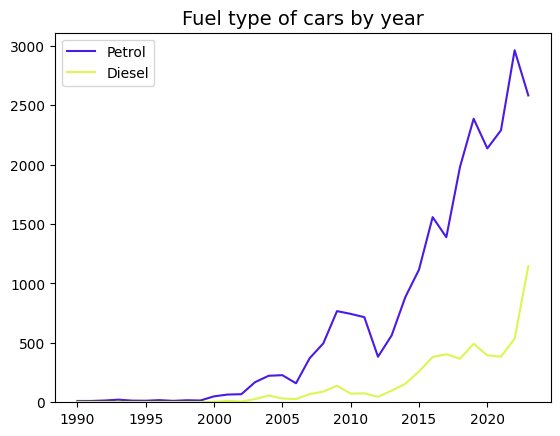

In [126]:
# Create fuel type by year line charts

fuel_count = df.groupby(['year_of_manufacture', 'fuel_type'], as_index = False).count()
fuel_count
petrol = fuel_count[(fuel_count['fuel_type'] == 'Petrol')]
diesel = fuel_count[(fuel_count['fuel_type'] == 'Diesel')]
hybrid = fuel_count[(fuel_count['fuel_type'] == 'Hybrid')]
electric = fuel_count[(fuel_count['fuel_type'] == 'Electric')]

plt.plot(petrol['year_of_manufacture'], petrol['brand'], label = 'Petrol', color = '#4a1be4')
plt.plot(diesel['year_of_manufacture'], diesel['brand'], label = 'Diesel', color = '#d9f852')
plt.legend()
plt.title('Fuel type of cars by year',fontsize=14) 
plt.ylim(0,)
plt.savefig('Fuel type of cars by year1.png')

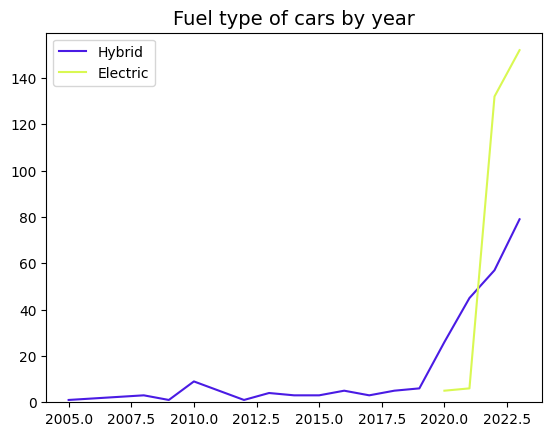

In [127]:
plt.plot(hybrid['year_of_manufacture'], hybrid['brand'], label = 'Hybrid', color = '#4a1be4')
plt.plot(electric['year_of_manufacture'], electric['brand'], label = 'Electric', color = '#d9f852')
plt.legend()
plt.title('Fuel type of cars by year',fontsize=14) 
plt.ylim(0,)
plt.savefig('Fuel type of cars by year2.png')

- Đường biểu thị số lượng ô tô chạy `Petrol` có nhiều biến động giảm ngắn hạn ở các năm 2012, 2017 và 2019 nhưng xu hướng chung tăng đến năm 2021; đến năm 2023 thì xe `Petrol` giảm xuống 10% so với năm 2020. 
- Đường biểu thị số lượng ô tô chạy động cơ `Diesel`có nhiều biến động và tăng nhẹ đến năm 2021 và tăng mạnh từ năm 2021 đến 2023, đến năm 2023 thì số lượng xe tăng gấp đôi so với năm 2021.
- Số lượng xe `Hybrid` có xu hướng đi ngang và số lượng không có tăng hoặc giảm đáng kể qua các năm 2005 - 2019 và tăng mạnh dần đều từ năm 2019 đến 2023.
- Xe chạy `Electric` khan hiếm từ các năm trước 2021 và hầu như chưa có bán chiếc nào từ năm 2020 trở về trước tuy nhiên từ năm 2021 trở đi xe điện đã tăng phi mã lên gần 25 lần ở năm 2023 so với năm 2021.

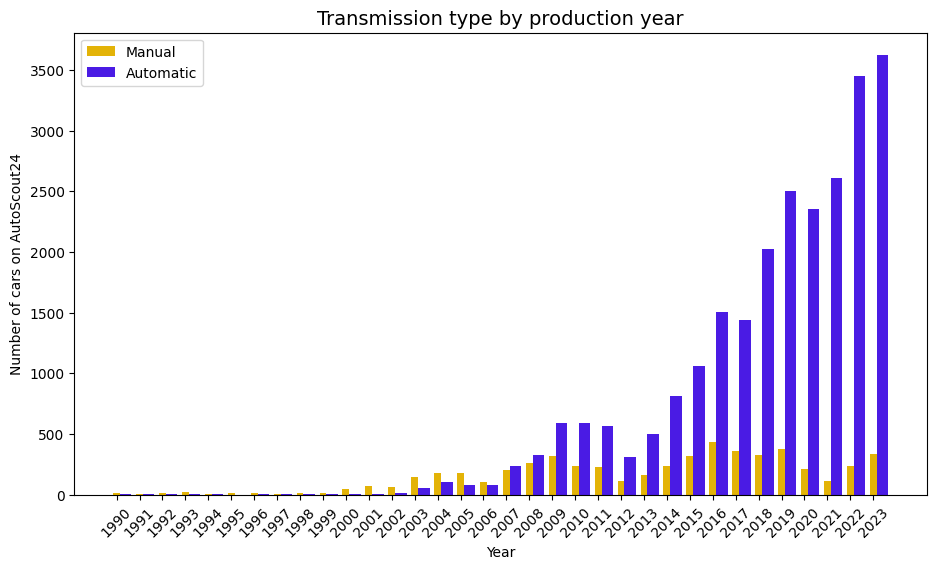

In [128]:
plt.figure(figsize=(11, 6))  # Chiều rộng là 10 inch, chiều cao là 6 inch

# Dữ liệu và xử lý biểu đồ
gear_count = df.groupby(['year_of_manufacture', 'transmission'], as_index=False).count()
X = gear_count['year_of_manufacture'].unique()
manual = gear_count[gear_count['transmission'] == 'Manual']
automatic = gear_count[gear_count['transmission'] == 'Automatic']

X_axis = np.arange(len(X))

# Vẽ biểu đồ cột
plt.bar(X_axis - 0, manual['brand'], 0.3, label='Manual', color='#e3b307')
plt.bar(X_axis + 0.4, automatic['brand'], 0.5, label='Automatic', color='#4a1be4')

# Thiết lập các thuộc tính cho biểu đồ
plt.xticks(X_axis, X, rotation=45)
plt.xlabel("Year")
plt.ylabel("Number of cars on AutoScout24")
plt.title("Transmission type by production year",fontsize=14)
plt.legend()
plt.savefig('Transmission type by production yearr.png')

Các offers có năm sản xuất trước năm 2006 loại `Transmission_type` là Manual hơn so với 'Automatic' chiếm 1 phần nhỏ , trong khi các offers có năm sản xuất sau năm 2006 thay đổi trái ngược khi các loại xe có `Transmission_type` là `Automatic` chiếm nhiều hơn và chiếm tỉ trọng tăng dần hơn rất nhiều lần so với `Manual`. Từ 2009, xe `Automatic` đã chiếm gấp nhiều lần tỉ trọng so với xe `Manual`, tới năm 2023 thì xe `Automatic` đã gấp 9 lần so với xe `Manual` .

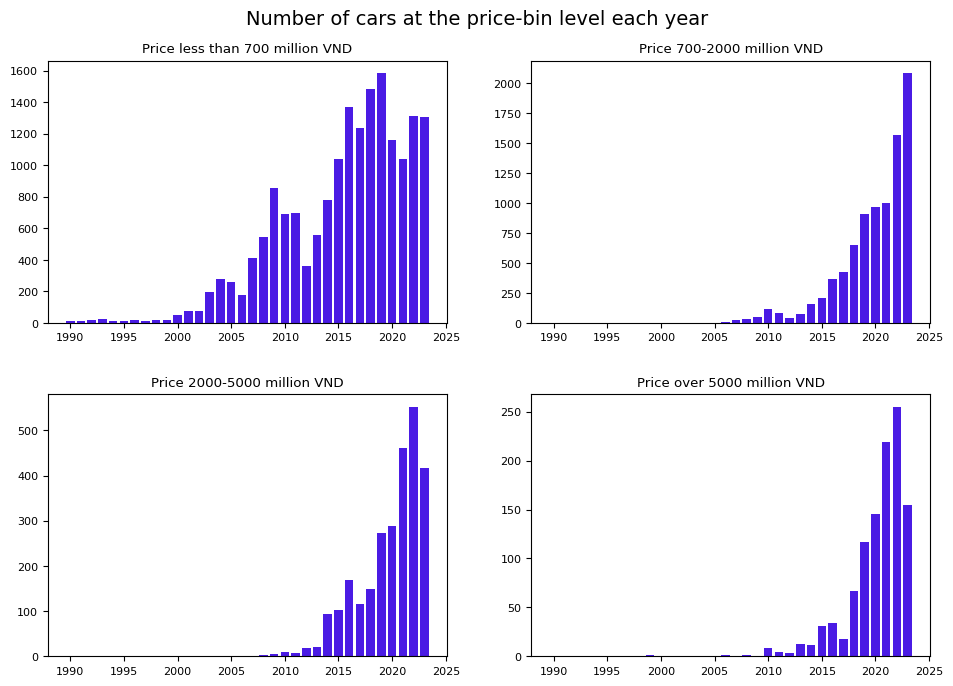

In [129]:
# Create bars that show how price groups are represented by production year
plt.rcParams['font.size'] = 8

price_bin_year = df.groupby(['price-bin', 'year_of_manufacture'], as_index = False, observed=False).count()
bin1 = price_bin_year[(price_bin_year['price-bin'] == '< 700 million VND')]
bin2 = price_bin_year[(price_bin_year['price-bin'] == '700-2000 million VND')]
bin3 = price_bin_year[(price_bin_year['price-bin'] == '2000-5000 million VND')]
bin4 = price_bin_year[(price_bin_year['price-bin'] == '5000+ million VND')]

fig, axs = plt.subplots(2, 2, figsize=(10, 7))
axs[0, 0].bar(bin1['year_of_manufacture'], bin1['brand'], label='< 700 million VND', color='#4a1be4')
axs[0, 0].set_title('Price less than 700 million VND')

axs[0, 1].bar(bin2['year_of_manufacture'], bin2['brand'], label='700-2000 million VND', color='#4a1be4')
axs[0, 1].set_title('Price 700-2000 million VND')

axs[1, 0].bar(bin3['year_of_manufacture'], bin3['brand'], label='2000-5000 million VND', color='#4a1be4')
axs[1, 0].set_title('Price 2000-5000 million VND')

axs[1, 1].bar(bin4['year_of_manufacture'], bin4['brand'], label='5000+ million VND', color='#4a1be4')
axs[1, 1].set_title('Price over 5000 million VND')

fig.tight_layout(pad=3.0)
fig.suptitle('Number of cars at the price-bin level each year', fontsize=14, y=1)
plt.ylim(0,)
plt.savefig('Number of cars at the price-bin level each year.png')

Nhìn chung những chiến các loại xe ở mọi phân khúc đều có xu hướng được bán nhiều hơn khi năm sản xuất của nó tăng lên và đều có sự suy giảm ở những năm 2012-2013.

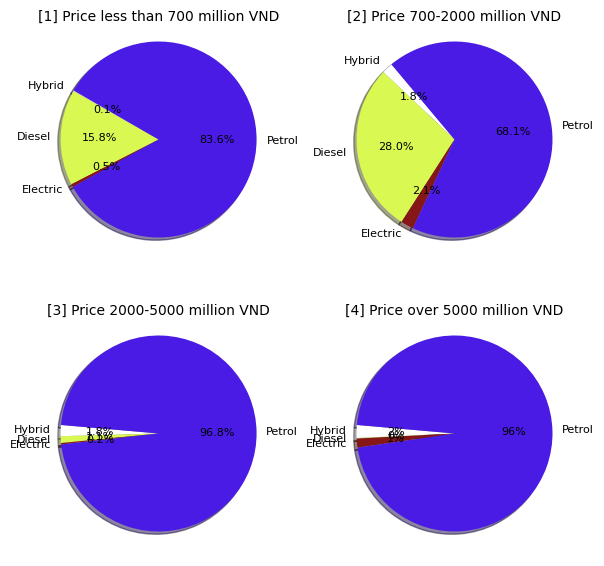

In [130]:

# Tạo các thanh hiển thị cách thể hiện các nhóm giá theo loại nhiên liệu
plt.rcParams['font.size'] = 8
fuel_order = ['Hybrid', 'Diesel', 'Electric', 'Petrol']


df['fuel_type'] = pd.Categorical(df['fuel_type'], categories=['Hybrid', 'Diesel', 'Electric', 'Petrol'], ordered=True)

price_bin_fuel = df.groupby(['price-bin', 'fuel_type'], as_index = False, observed=False).count()


bin12 = price_bin_fuel[(price_bin_fuel['price-bin'] == '< 700 million VND')]
bin22 = price_bin_fuel[(price_bin_fuel['price-bin'] == '700-2000 million VND')]
bin32 = price_bin_fuel[(price_bin_fuel['price-bin'] == '2000-5000 million VND')]
bin42 = price_bin_fuel[(price_bin_fuel['price-bin'] == '5000+ million VND')]

# Tạo từng biểu đồ cho 5 phần
fig1, axs1 = plt.subplots(2, 2, figsize=(7, 7))
axs1[0, 0].pie(bin12['brand'], labels = bin12['fuel_type'], autopct='%1.1f%%', colors = ['#ffffff', '#d9f852',  '#851717', '#4a1be4'], shadow=True, startangle=150, radius=1)
axs1[0, 0].set_title('[1] Price less than 700 million VND',fontsize=10, y=0.95)

axs1[0, 1].pie(bin22['brand'], labels=bin32['fuel_type'], autopct='%1.1f%%', colors = ['#ffffff', '#d9f852',  '#851717', '#4a1be4'],shadow=True, startangle= 130, radius=1)
axs1[0, 1].set_title('[2] Price 700-2000 million VND', fontsize=10, y=0.95)

axs1[1, 0].pie(bin32['brand'], labels=bin32['fuel_type'], autopct='%1.1f%%', colors = ['#ffffff', '#d9f852',  '#851717', '#4a1be4'],shadow=True, startangle=175, radius=1)
axs1[1, 0].set_title('[3] Price 2000-5000 million VND', fontsize=10, y=0.95)

axs1[1, 1].pie(bin42['brand'], labels=bin42['fuel_type'], autopct='%.0f%%', colors = ['#ffffff', '#d9f852',  '#851717', '#4a1be4'], shadow=True, startangle=175 ,  radius=1)
axs1[1, 1].set_title('[4] Price over 5000 million VND', fontsize=10, y=0.95)

plt.savefig('Fuel types in price categories ratio.png')

Xe chạy `Petrol` chiếm tỷ lệ lớn (82.7%) trong nhóm các xe có giá thấp hơn 700 triệu VNĐ . Tỷ lệ này giảm (13,2%) ở nhóm xe giá 700-2000 triệu VNĐ. Ở nhóm xe 2tỷ-5tỷ và nhóm xe trên 5 tỷ VNĐ thì tỷ lệ xe `Petrol` chiếm gần như toàn bộ thị phần, lần lượt là 96,6% và 96%  . Một loại nhiên liệu khác có xu hướng đại diện nhiều hơn ở nhóm có giá thấp hơn 2 tỷ đó là `Diesel`. Tuy nhiên thì xe sử dụng `Diesel` lại có giảm hơn so với các loại xe khác (Hybrid và Electric) ở các nhóm thứ 4 và thứ 5 .

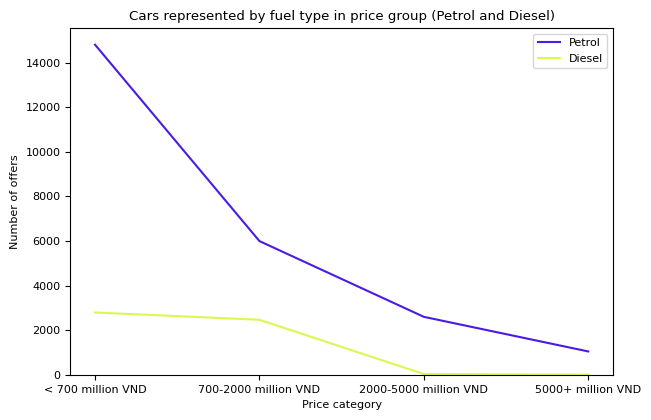

In [131]:
fuel_count1 = df.groupby(['price-bin', 'fuel_type'], as_index = False, observed=False).count()
fuel_count
petrol = fuel_count1[(fuel_count1['fuel_type'] == 'Petrol')]
diesel = fuel_count1[(fuel_count1['fuel_type'] == 'Diesel')]
hybrid = fuel_count1[(fuel_count1['fuel_type'] == 'Hybrid')]
electric = fuel_count1[(fuel_count1['fuel_type'] == 'Electric')]

fig1, axs1 = plt.subplots(figsize=(7, 4.5))
plt.plot(petrol['price-bin'], petrol['brand'], label = 'Petrol', color = '#4a1be4')
plt.plot(diesel['price-bin'], diesel['brand'], label = 'Diesel', color = '#d9f852')
plt.legend()
plt.title('Cars represented by fuel type in price group (Petrol and Diesel)') 
plt.ylabel('Number of offers')
plt.xlabel('Price category')
plt.ylim(0,)
plt.savefig('Cars represented by fuel type in price group (Petrol and Diesel)')

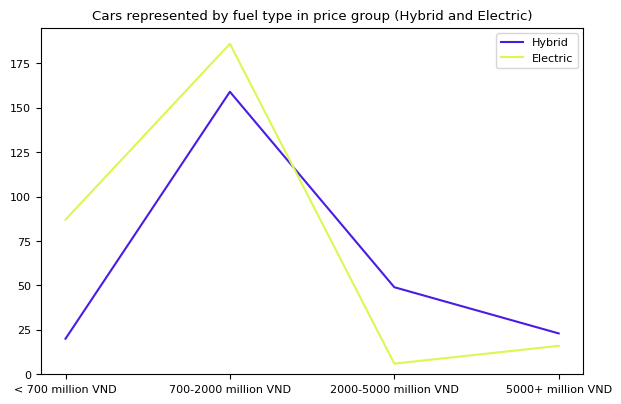

In [132]:
fig1, axs1 = plt.subplots(figsize=(7, 4.5))
plt.plot(hybrid['price-bin'], hybrid['brand'], label = 'Hybrid', color = '#4a1be4')
plt.plot(electric['price-bin'], electric['brand'], label = 'Electric', color = '#d9f852')
plt.legend()
plt.title('Cars represented by fuel type in price group (Hybrid and Electric)') 
plt.ylim(0,)
plt.savefig('Cars represented by fuel type in price group (Hybrid and Electric)')

- Nhìn chung, 2 loại xe chiếm số lượng nhiều nhất là `Petrol` và `Diesel` đều có xu hướng ít được ưa thích hơn, trong khi giá tăng lại tăng lên.
- Còn đối với xe `Hybrid` và `Electronic` thì cũng có xu hướng này chỉ ở phân khúc xe có giá lớn hơn 2 tỷ. Còn dưới 2 tỷ thì ngược lại

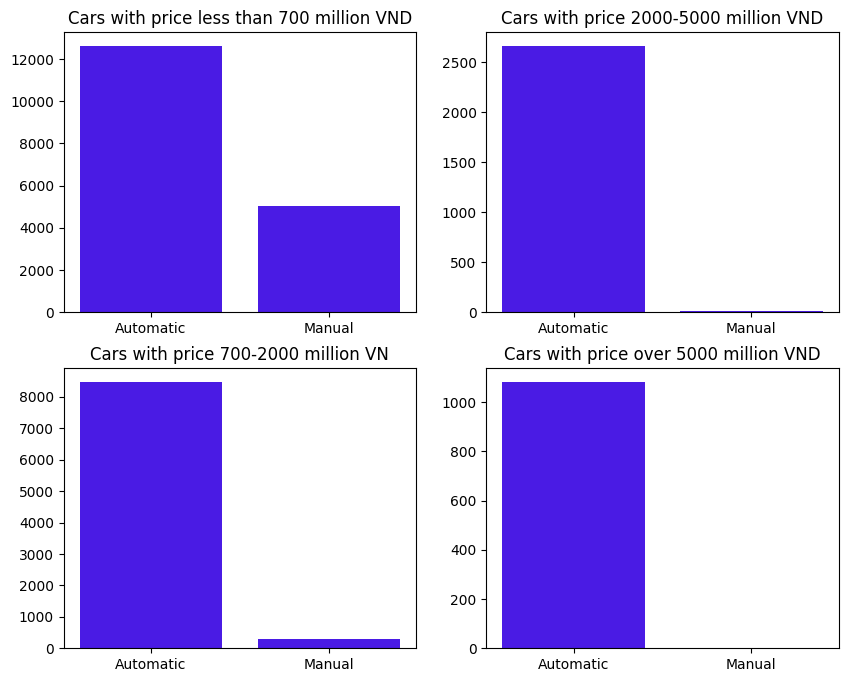

In [133]:
# Create bar charts, that show how gear type 'Manual' and 'Automatic' represented in price groups 

plt.rcParams['font.size'] = 10

cars_ma = df.loc[df['transmission'] != 'Semi-Automatic']
price_bin_year1 = cars_ma.groupby(['price-bin', 'transmission'], as_index = False, observed=False).count()
bin11 = price_bin_year1[(price_bin_year1['price-bin'] == '< 700 million VND')]
bin21 = price_bin_year1[(price_bin_year1['price-bin'] == '700-2000 million VND')]
bin31 = price_bin_year1[(price_bin_year1['price-bin'] == '2000-5000 million VND')]
bin41 = price_bin_year1[(price_bin_year1['price-bin'] == '5000+ million VND')]

fig1, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].bar(bin11['transmission'], bin11['brand'], label = '< 700 million VND', color = '#4a1be4')
axs[0, 0].set_title('Cars with price less than 700 million VND')
axs[1, 0].bar(bin21['transmission'], bin21['brand'], label = '700-2000 million VN', color = '#4a1be4')
axs[1, 0].set_title('Cars with price 700-2000 million VN')
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].bar(bin31['transmission'], bin31['brand'], label = '2000-5000 million VND', color = '#4a1be4')
axs[0, 1].set_title('Cars with price 2000-5000 million VND')
axs[1, 1].bar(bin41['transmission'], bin41['brand'], label = '5000+ million VND', color = '#4a1be4')
axs[1, 1].set_title('Cars with price over 5000 million VND')
fig.tight_layout()
plt.ylim(0,)
plt.savefig('Cars with price Gear_trend.png')

Dựa trên biểu đồ chúng ta có thể thấy ở những chiếc xe có giá dưới 700 triệu VNĐ thì loại xe có hộp số 'Manual' được tìm thấy nhiều hơn, tuy nhiên thì loại xe `Automatic` vẫn chiếm nhiều hơn gấp 3 lần. Trong khi đó ở các phân khúc xe có giá trị lớn hơn 700 triệu VNĐ thì xe có hộp số `Manual` chiếm càng ít và không đáng kể. Giá càng cao thì có càng ít xe `Manual`.

(0.0, 9.45)

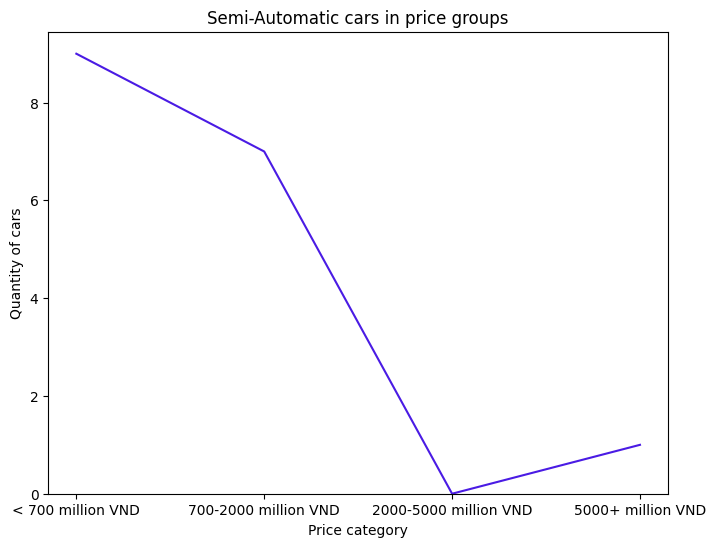

In [134]:
# Create bar charts, that show how gear type 'Semi-automatic' represented in price groups 
fig1, axs = plt.subplots(figsize=(8, 6))
cars_sa = df.loc[df['transmission'] == 'Semi-Automatic']
price_bin_year12 = cars_sa.groupby(['price-bin', 'transmission'], as_index = False, observed=False).count()

plt.plot(price_bin_year12['price-bin'], price_bin_year12['brand'], color = '#4a1be4')

plt.xlabel('Price category')
plt.ylabel('Quantity of cars')
plt.title('Semi-Automatic cars in price groups')
plt.ylim(0,)

Ở loại xe `Semi-Automatic` thì đa số xe nằm ở phân khúc dưới 700 triệu VNĐ

## Generating top/stats information:

In [135]:
# Add columns with value_counts of model and make to dataframe

df['grade_available'] = df['brand_grade'].map(df['brand_grade'].value_counts())
df['brand_count'] = df['brand'].map(df['brand'].value_counts())
df.T

,0,1,2,3,4,5,6,7,8,9,...,30642,30643,30644,30645,30646,30647,30648,30649,30650,30651
car_price,249.00,4286.00,885.00,754.00,850.00,299.00,984.00,1229.00,688.00,830.00,...,430.00,499.00,220.00,395.00,740.00,595.00,2388.00,595.00,1459.00,3979.00
origin,Domestic assembly,Imported,Domestic assembly,Imported,Domestic assembly,Domestic assembly,Domestic assembly,Imported,Domestic assembly,Domestic assembly,...,Domestic assembly,Imported,Domestic assembly,Domestic assembly,Domestic assembly,Domestic assembly,Imported,Imported,Domestic assembly,Imported
condition,New car,New car,New car,New car,New car,New car,New car,New car,New car,New car,...,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car,Used car
car_model,Truck,SUV,Crossover,SUV,Crossover,Van/Minivan,SUV,SUV,Bán tải / Pickup,Bán tải / Pickup,...,Sedan,Crossover,Hatchback,SUV,Sedan,SUV,Sedan,Bán tải / Pickup,SUV,SUV
n_mileage,0,0,0,0,0,0,0,0,0,0,...,21000,0,0,38000,67000,55000,28000,158000,30000,10500
exterior_color,White,Black,Silver,White,Silver,White,White,Copper,Grey,Black,...,Copper,White,Red,White,Black,Silver,Black,Yellow,White,Green
interior_color,gray,Black,Brown,Black,gray,gray,Black,Black,Black,Black,...,Cream,Black,Black,Black,Black,Black,Cream,Black,Cream,Black
num_of_doors,2-door,5-door,5-door,5-door,5-door,5-door,5-door,5-door,4-door,4-door,...,4-door,5-door,5-door,5-door,4-door,5-door,4-door,4-door,5-door,5-door
seating_capacity,2-seat,7-seat,8-seat,5-seat,8-seat,2-seat,7-seat,7-seat,5-seat,5-seat,...,5-seat,5-seat,5-seat,5-seat,5-seat,7-seat,5-seat,5-seat,5-seat,5-seat
fuel_type,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Diesel,Diesel,...,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol,Petrol


In [139]:
# Find out top 10 of models, which are most represented

grade_avg = df[['brand', 'brand_grade','car_price', 'grade_available', 'n_mileage']]
grade_avg = grade_avg.groupby(['brand', 'brand_grade'], as_index = False).mean()
grade_avg = grade_avg.sort_values(by = 'grade_available', ascending = False) 
top10_grade = grade_avg.head(10)
top10_grade.reset_index(drop = True, inplace = True)
top10_grade

,brand,brand_grade,car_price,grade_available,n_mileage
0,Ford,Ford Ranger,680.08,1424.00,148695.84
1,Toyota,Toyota Vios,403.87,1011.00,109362.47
2,Mazda,Mazda 3,532.88,837.00,162392.82
3,Kia,Kia Morning,241.63,782.00,5754189.87
4,Mercedes Benz,Mercedes Benz GLC,1807.72,759.00,21721.53
5,Toyota,Toyota Camry,734.57,753.00,81012.25
6,Toyota,Toyota Innova,429.97,727.00,140771.54
7,Toyota,Toyota Fortuner,766.73,722.00,349352.41
8,Ford,Ford Everest,964.99,691.00,75915.27
9,Mercedes Benz,Mercedes Benz C class,1132.68,672.00,62904.51


In [140]:
rare_grade = df.loc[df['grade_available'] == 1]
rare_grade[['brand', 'brand_grade', 'car_price', 'car_model', 'n_mileage']]

,brand,brand_grade,car_price,car_model,n_mileage
590,Cadillac,Cadillac STS,589.00,Sedan,90000
755,Infiniti,Infiniti FX,480.00,Crossover,89000
893,Smart,Smart Fortwo,450.00,Hatchback,0
1108,Rolls Royce,Rolls Royce Silver,8300.00,Sedan,50000
1422,Citroen,Citroen DS3,420.00,Hatchback,51000
...,...,...,...,...,...
28377,Luxgen,Luxgen U7,279.00,SUV,0
29369,Mazda,Mazda 5,695.00,SUV,54000
29392,Mercedes Benz,Mercedes Benz Khác,250.00,Sedan,1000000
30457,Mitsubishi,Mitsubishi Grunder,429.00,Sedan,91000


In [141]:
#Find out top 10 of brands, which are more represented and average stats

brand_avg = df[['brand','car_price', 'brand_count', 'n_mileage']]
brand_avg = brand_avg.groupby(['brand'], as_index = False).mean()
brand_avg = brand_avg.sort_values(by = 'brand_count', ascending = False) 
top10_brand = brand_avg.head(10)
top10_brand.reset_index(drop = True, inplace = True)
top10_brand

,brand,car_price,brand_count,n_mileage
0,Toyota,812.75,5544.00,116475.61
1,Hyundai,585.50,3531.00,281788.19
2,Ford,787.21,3334.00,103319.84
3,Mercedes Benz,2654.76,3123.00,40666.76
4,Kia,505.91,2961.00,1642254.92
5,Mazda,596.18,2220.00,93872.28
6,Mitsubishi,562.63,1378.00,118118.08
7,Honda,595.51,1220.00,59124.23
8,Lexus,3870.37,929.00,40133.98
9,VinFast,678.58,790.00,70907.65


In [142]:
# Find out rare brand of cars

rare10_brand = df.loc[df['brand_count'] == 1]
rare10_brand.reset_index(drop = True, inplace = True)
rare10_brand[['brand', 'brand_grade', 'car_price', 'car_model', 'n_mileage', 'brand_count']]

,brand,brand_grade,car_price,car_model,n_mileage,brand_count
0,Citroen,Citroen DS3,420.00,Hatchback,51000,1
1,SYM,SYM V5,79.00,Van/Minivan,632894,1
2,Aston Martin,Aston Martin Rapide,5000.00,Sedan,11000,1
3,Scion,Scion Xd,585.00,Hatchback,0,1
4,Tesla,Tesla X,7900.00,SUV,600,1
5,Dongfeng,Dongfeng Khác,450.00,Truck,10000,1
6,Pontiac,Pontiac Solstice,1090.00,Convertible/Cabriolet,40000,1
7,Hummer,Hummer H2,3300.00,SUV,0,1
8,Proton,Proton Wira,51.00,Sedan,324068,1
9,Mekong,Mekong Premio,180.00,Bán tải / Pickup,34000,1


In [144]:
# Top 10 most expensive cars represented

cars_sorted = df.sort_values(by = 'car_price', ascending = False)
top10_expensive = cars_sorted.head(10)
top10_expensive.reset_index(drop = True, inplace = True)
top10_expensive[['brand_grade', 'car_model', 'car_price', 'n_mileage']]

,brand_grade,car_model,car_price,n_mileage
0,Ferrari SF90 Stradale,Coupe,54000.00,0
1,Rolls Royce Cullinan,SUV,46000.00,0
2,Rolls Royce Cullinan,SUV,45000.00,0
3,Rolls Royce Cullinan,SUV,45000.00,0
4,Rolls Royce Ghost,Sedan,39999.00,6200
5,Rolls Royce Cullinan,SUV,39990.00,0
6,Rolls Royce Cullinan,SUV,39900.00,7000
7,Rolls Royce Ghost,Sedan,39000.00,6300
8,Rolls Royce Ghost,Sedan,39000.00,6000
9,Rolls Royce Cullinan,SUV,39000.00,0


In [145]:
# Top 10 cheapest cars represented on AutoScout24

top10_cheapest = cars_sorted.tail(10)
top10_cheapest = top10_cheapest.sort_values(by = 'car_price', ascending = True)
top10_cheapest.reset_index(drop = True, inplace = True)
top10_cheapest[['brand', 'brand_grade', 'car_price', 'car_model', 'n_mileage']]

,brand,brand_grade,car_price,car_model,n_mileage
0,Kia,Kia Pride,18.00,Sedan,0
1,Mitsubishi,Mitsubishi L300,21.00,Van/Minivan,0
2,Mitsubishi,Mitsubishi L300,25.00,Van/Minivan,30000
3,Daewoo,Daewoo Matiz,25.00,Hatchback,0
4,Nissan,Nissan Sunny,25.00,Sedan,125000
5,Kia,Kia Pride,27.00,Sedan,0
6,Mitsubishi,Mitsubishi Canter,28.00,Sedan,5000000
7,Toyota,Toyota Hiace,28.00,Van/Minivan,2563
8,Toyota,Toyota Hiace,28.00,Van/Minivan,400000
9,Daewoo,Daewoo Matiz,28.00,Hatchback,0


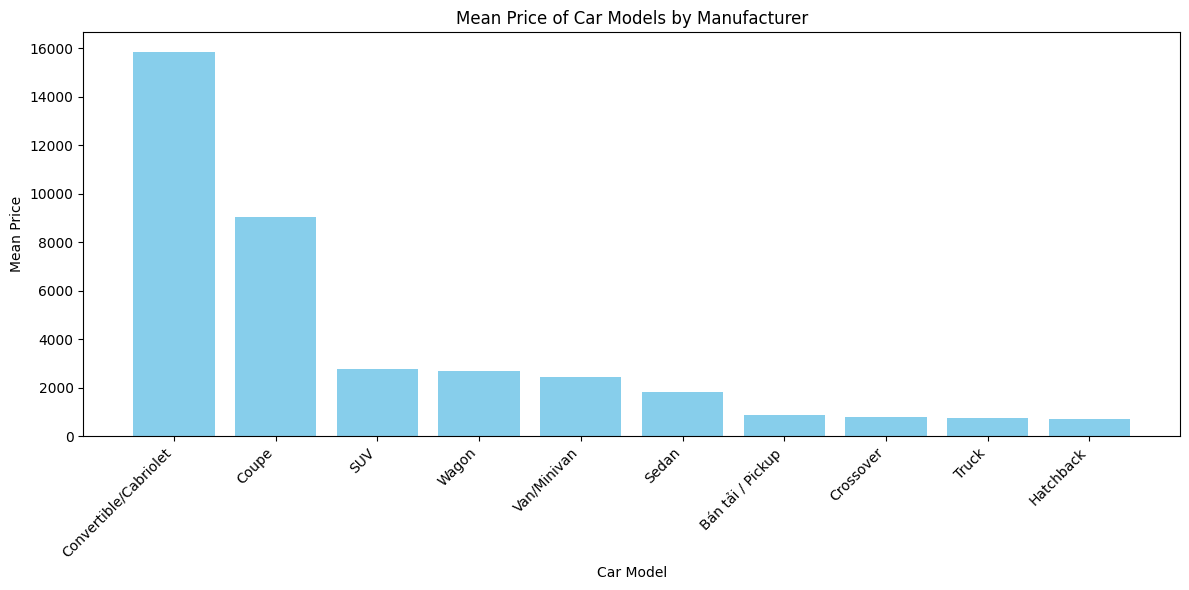

In [146]:
# Nhóm theo 'car_model' và 'year_of_sản xuất', tính giá trung bình cho mỗi nhóm
grouped_data = df.groupby(['car_model', 'year_of_manufacture'])['car_price'].mean().reset_index()

# Sắp xếp dữ liệu được nhóm theo giá trung bình theo thứ tự giảm dần
sorted_data = grouped_data.sort_values(by='car_price', ascending=False)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.bar(sorted_data['car_model'], sorted_data['car_price'], color='skyblue')
plt.xlabel('Car Model')
plt.ylabel('Mean Price')
plt.title('Mean Price of Car Models by Manufacturer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

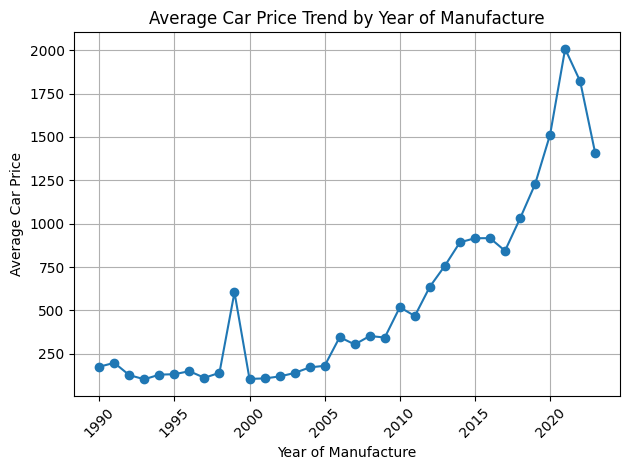

In [147]:
# Tạo một DataFrame mới chỉ chứa cột 'car_price' và 'year_of_manufacture'
price_year_df = df[['car_price', 'year_of_manufacture']]

# Nhóm giá cả theo năm và tính giá trung bình cho mỗi năm
average_price_year = price_year_df.groupby('year_of_manufacture')['car_price'].mean()

# Vẽ biểu đồ đường cho xu hướng giá cả theo năm
plt.plot(average_price_year.index, average_price_year.values, marker='o', linestyle='-')

# Đặt tiêu đề và nhãn trục cho biểu đồ
plt.title('Average Car Price Trend by Year of Manufacture')
plt.xlabel('Year of Manufacture')
plt.ylabel('Average Car Price')

# Hiển thị biểu đồ
plt.xticks(rotation=45)  # Xoay nhãn trục x để dễ đọc hơn
plt.grid(True)  # Hiển thị lưới cho biểu đồ
plt.tight_layout()  # Tăng khả năng hiển thị cho các nhãn
plt.show()
